## Imports

In [ ]:
import torch
import torchtext
from models import AWE_Encoder,Classifier,Unidirectional_LSTM,Bidirectional_LSTM,MaxPool_Bidirectional_LSTM
from utils import SNLI_data, SNLI_Dataloader
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn import metrics

In [2]:
torch.manual_seed(1)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Loading the test dataloader

In [3]:
snli_data = SNLI_data()
train_iter, dev_iter, test_iter = torchtext.data.BucketIterator.splits(datasets=(snli_data.train_data, snli_data.valid_data, snli_data.test_data),
                                                batch_sizes=(64,64,64),
                                                sort_key=lambda x: x.premise,
                                                sort_within_batch=True)
                                                
train_loader = SNLI_Dataloader(train_iter)
test_loader = SNLI_Dataloader(test_iter)

## Loading the model

In [4]:
class Enc_MLP(torch.nn.Module):
    def __init__(self, encoder_type):
        super(Enc_MLP, self).__init__()
        
        self.embedding_layer = torch.nn.Embedding.from_pretrained(snli_data.vocabulary.vectors, freeze=True, padding_idx=1)
        if encoder_type == "awe":
            self.encoder = AWE_Encoder()
            self.net = Classifier("awe", 0)
        elif encoder_type == "uni_lstm":
            self.encoder = Unidirectional_LSTM()
            self.net = Classifier("uni_lstm", 2048)
        elif encoder_type == "bi_lstm":
            self.encoder = Bidirectional_LSTM()
            self.net = Classifier("bi_lstm", 2 * 2048)
        elif encoder_type == "pooled_bi_lstm":
            self.encoder = MaxPool_Bidirectional_LSTM()
            self.net = Classifier("pooled_bi_lstm", 2 * 2048)

    def forward(self, premise:torch.tensor, premise_length:torch.tensor, hypothesis:torch.tensor, hypothesis_length:torch.tensor) -> torch.tensor:
        premise = self.embedding_layer(premise)
        hypothesis = self.embedding_layer(hypothesis)    
        u = self.encoder(premise, premise_length)
        v = self.encoder(hypothesis, hypothesis_length)
        classifier_input = torch.cat([u, v, torch.abs(u-v), u*v], 1)
        output = self.net(classifier_input)
        return output

In [5]:
def import_model(encoder_type):

    map_loc = torch.device('cpu')

    # Load from checkpoint depending on the encoder type
    if (encoder_type == 'awe'):
        model = Enc_MLP("awe")
        checkpoint = torch.load('checkpoints/awe/best_model.pt',map_location=map_loc)
        model.load_state_dict(checkpoint['model_state_dict']) 
  
    elif (encoder_type == 'uni_lstm'):
        model = Enc_MLP("uni_lstm")
        checkpoint = torch.load('checkpoints/uni_lstm/best_model.pt',map_location=map_loc)
        model.load_state_dict(checkpoint['model_state_dict']) 

    elif (encoder_type == 'bi_lstm'):
        model = Enc_MLP("bi_lstm")
        checkpoint = torch.load('checkpoints/bi_lstm/best_model.pt',map_location=map_loc)
        model.load_state_dict(checkpoint['model_state_dict'])       

    elif (encoder_type == 'pooled_bi_lstm'):
        model = Enc_MLP("pooled_bi_lstm")
        checkpoint = torch.load('checkpoints/pooled_bi_lstm/best_model.pt',map_location=map_loc)
        model.load_state_dict(checkpoint['model_state_dict']) 
            
    model.eval()

    return model

AWE_model = import_model("awe")
UniLSTM_model = import_model('uni_lstm')
BiLSTM_model = import_model('bi_lstm')
PooledBiLSTM_model = import_model('pooled_bi_lstm')

## Summary of train & validation results - SNLI

The following table provides the results for the accuracy of the training and the validation for each model. 


| Encoder Type | Train accuracy | Validation accuracy |
|--------------|----------------|---------------------|
| AWE          | 0.6814         | 0.6870              |
| UniLSTM      | 0.9037         | 0.8116              |
| BiLSTM       | 0.9425         | 0.8086              |
| PooledBiLSTM | 0.9012         | 0.8270              |


The average word embedding encoder represents each sentence as the average of the word embeddings of the words in a given sentence. This model is computationally simple and efficient, but it lacks the ability to capture the sequential and contextual information of the sentence. Obviously, this model is not effective in capturing the meaning of sentences, where the context and sequence of words are critical in determining the correct label for the premise-hypothesis pair. As expected, the AWE - encoder achieves the lower accuracy, but still it is nowhere near random performance (i.e. 1/number of different labels). 

The unidirectional LSTM encoder uses a Long Short-Term Memory (LSTM) layer to learn the contextual representation of each word in a sentence. It can capture the sequential and contextual information of the sentence. The unidirectional LSTM model processes the sentence in a forward direction. The last hidden state of the LSTM layer is used as the sentence representation.
The unidirectional LSTM model outperforms the average word embedding model on the NLI task. The LSTM cell obviously enhances the model and makes it perform a lot better than the simple AWE encoder. However, since it processes information in a single direction, it only considers the previous words in the sentence and not future words. This limitation can affect the model on large and complex sentences, but for this task it is rather unclear.

The bidirectional LSTM encoder processes the sentence in both the forward and backward directions. The forward and backward outputs are concatenated to form the final sentence representation.
The encoder is now able to capture the context from prior and later words, thus producing more useful encoded embeddings for the classifier. This is reflected from the fact that the bidirectional LSTM encoder makes the model perform better than the previous models. Nevertheless, this extra performance comes with a higher computational cost, as we have more model parameters in this case. 

The bidirectional LSTM encoder with Max Pooling can be considered an extension of the previous model. This encoder makes the model achieve the highest accuracy in every split of the dataset. The Max Pooling mechanism most likely results in more compact sentence representations and makes model able to determine which part of the sentence is more important.

The following table summarizes the results on the transfer tasks as the original paper

| Encoder Type | Macro | Micro |
|--------------|----------|---------------|
| AWE          |     80.67     |    80.14           |
| UniLSTM      |   79.95       |    80.22           |
| BiLSTM       |    82.59      |    81.59           |
| PooledBiLSTM |     84.23     |     83.17          |

Macro computes an aggregated score that corresponds to the classical average of dev (i.e. valid) accuracies, whereas the ”micro” score is a sum of the dev accuracies, weighted by the number of dev samples.


## SentEval Results

The following table provides an overview of the results on SentEval for each model.

| Encoder - Split | MR | CR | SUBJ | MPQA | SST2 | TREC | MRPC (Acc / F1)| SICKRelatedness | SICKEntailment | STS14 (Weighted Avg / Avg) |
|--------------|:--:|----|------|------|------|------|------|-----------------|----------------|-------|
| AWE - Dev    |  78.05  | 79.96  |  91.7  |  88.16  | 79.01  | 74.38  | 74.29         |   pearson : 0.7972    |   80.8   |          -            |
| AWE - Test   |  77.57  |  78.75 |  91.21 |  87.66  | 80.18  | 83     | 72.87 / 81.4  |   pearson : 0.7992 , spearman : 0.7182    |   78.53  |   pearson : 0.5532 , spearman : 0.5623 / pearson : 0.546, spearman : 0.5563       |
| UniLSTM - Dev     |  75.5  |  79.92  |  87.62    |  88.44    | 78.56     |  66.98    |  74.19            |   pearson : 0.8594         |    82.4       |    -   |
| UniLSTM - Test    |  74.2  |  78.78  |  87.21    |  88.22    | 79.02    |  77.8     |  73.74 / 81.68    |    pearson : 0.8584 , spearman : 0.7952          |    84.29           | pearson : 0.6104 , spearman : 0.5893 / pearson : 0.599, spearman : 0.5795       |
| BiLSTM - Dev     | 76.36   | 80.06   |  90.8    | 88.43 |  78.9    |  83.14   |  74.58            |   pearson : 0.8692         |     84.2       |   -    |
| BiLSTM - Test    |  75.51  | 78.97   |  90.22    | 88.16 |  78.2    |  86    |  73.16 / 81.68    |   pearson : 0.87 , spearman : 0.811              |    84.84       |  pearson : 0.616 , spearman : 0.5888 / pearson : 0.5969, spearman : 0.5676       |
| PooledBiLSTM - Dev  | 79.01   | 83.9   |  92.95    |  89.05    |  81.19    |  85.31   | 75.44          |   pearson : 0.8627         |    85.0     |  -     |
| PooledBiLSTM - Test | 78.35   | 82.78   |  92.4    |  88.52     |  82.32    |  84.4    | 74.72 / 82.41  |   pearson : 0.8766 , spearman : 0.8171         |    84.45    |  pearson : 0.6215 , spearman : 0.6051 / pearson : 0.5967, spearman : 0.583      |



 Displaying results from tensorboard 



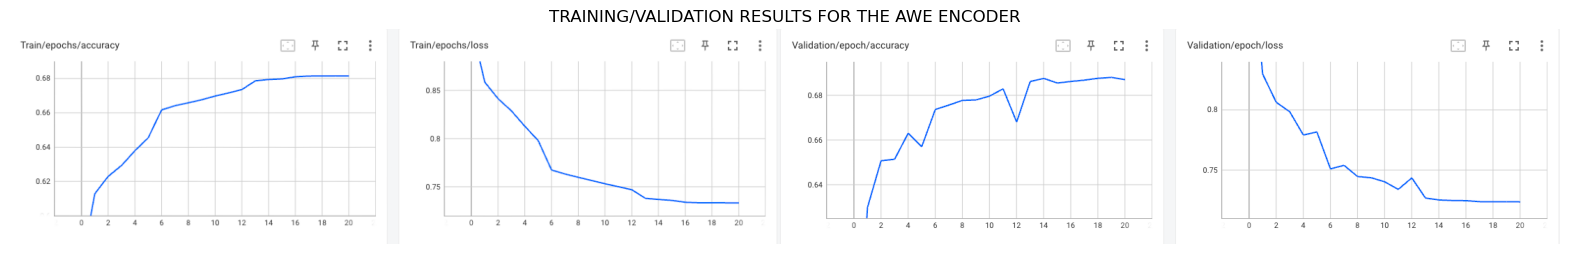

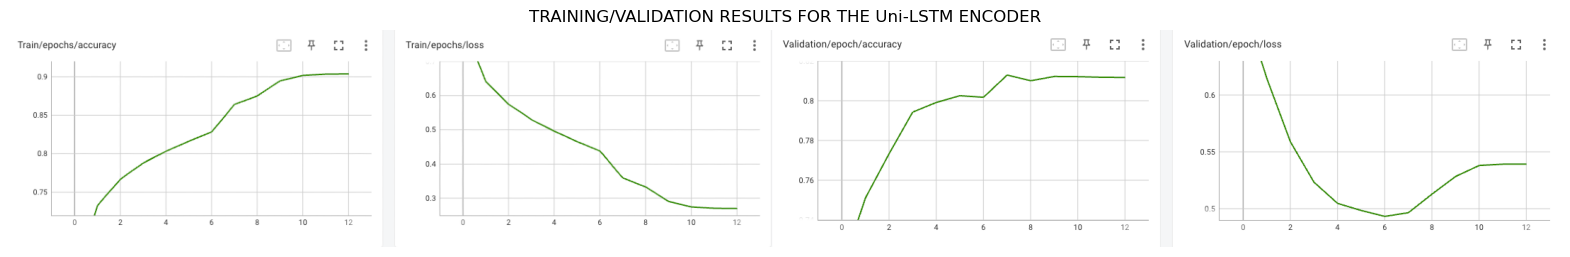

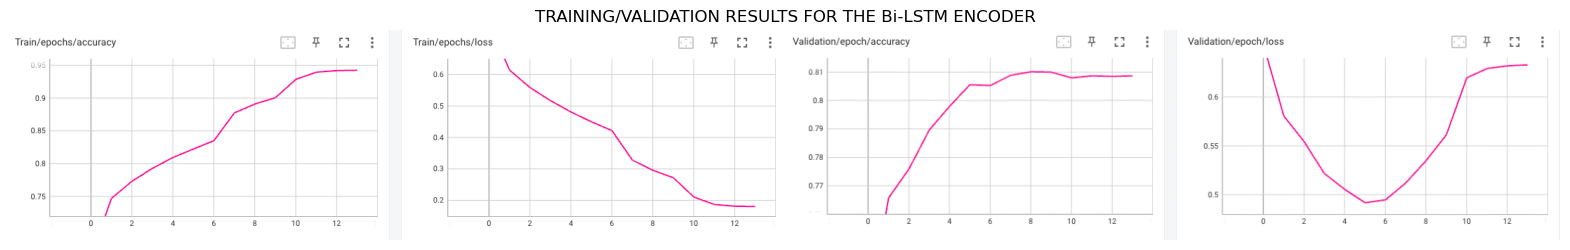

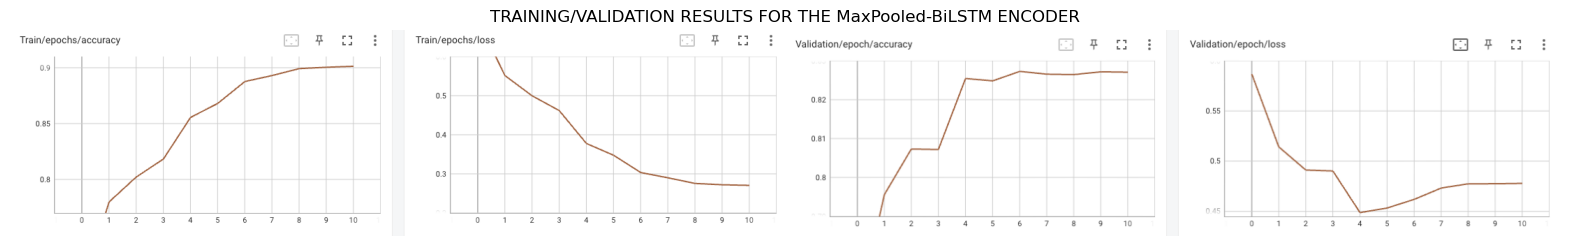

In [6]:
# Import modules
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Read images
img1 = mpimg.imread('tb_images/awe.png')
img2 = mpimg.imread('tb_images/uni.png')
img3 = mpimg.imread('tb_images/bi.png')
img4 = mpimg.imread('tb_images/pooled_bi.png')
print("\n Displaying results from tensorboard \n")
plt.figure(figsize=(20,8))
plt.title("TRAINING/VALIDATION RESULTS FOR THE AWE ENCODER")
plt.axis('off')
plt.imshow(img1)
plt.show()
plt.figure(figsize=(20,8))
plt.title("TRAINING/VALIDATION RESULTS FOR THE Uni-LSTM ENCODER")
plt.axis('off')
plt.imshow(img2)
plt.show()
plt.figure(figsize=(20,8))
plt.title("TRAINING/VALIDATION RESULTS FOR THE Bi-LSTM ENCODER")
plt.axis('off')
plt.imshow(img3)
plt.show()
plt.figure(figsize=(20,8))
plt.title("TRAINING/VALIDATION RESULTS FOR THE MaxPooled-BiLSTM ENCODER")
plt.axis('off')
plt.imshow(img4)
plt.show()

## Performance check on test dataset

In [7]:
def test_model(model, test_dataloader, device_type):

    eval_acc = 0
    eval_loss = 0
    total_labels = []
    total_predictions = []
    model.eval()
    loss_module = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        for premise, hypothesis, labels in tqdm(test_dataloader):
            premise_sentence = premise[0].to(device_type)
            premise_length = premise[1].to(device_type)
            hypothesis_sentence = hypothesis[0].to(device_type)
            hypothesis_length = hypothesis[1].to(device_type)
            labels = labels.to(device_type)
            out = model(premise_sentence,premise_length, hypothesis_sentence, hypothesis_length)
            loss = loss_module(out,labels)
            eval_loss += loss.detach().item()
            preds = torch.argmax(out, dim=1)
            accuracy = torch.sum(preds == labels, dtype=torch.float32) / out.shape[0]
            eval_acc += accuracy
            total_labels.append(labels)
            total_predictions.append(preds)

        eval_loss /= len(test_dataloader)
        eval_acc /= len(test_dataloader)
        
    return eval_loss, eval_acc, total_predictions, total_labels

In [8]:
_, test_acc_AWE, _,_ = test_model(AWE_model, test_loader, 'cpu')
_, test_acc_UniLSTM, _,_ = test_model(UniLSTM_model, test_loader, 'cpu')
_, test_acc_BiLSTM, _,_ = test_model(BiLSTM_model, test_loader, 'cpu')
_, test_acc_PooledBiLSTM, pooled_preds,pooled_labels= test_model(PooledBiLSTM_model, test_loader, 'cpu')
print("Test accuracy of AWE :", "%.2f"% (100*test_acc_AWE.item()), "%")
print("Test accuracy of UniLSTM :", "%.2f"% (100*test_acc_UniLSTM.item()), "%")
print("Test accuracy of BiLSTM :", "%.2f"% (100*test_acc_BiLSTM.item()), "%")
print("Test accuracy of PooledBiLSTM :", "%.2f"% (100*test_acc_PooledBiLSTM.item()), "%")

100%|██████████| 154/154 [04:47<00:00,  1.87s/it]

Test accuracy of AWE : 68.75 %
Test accuracy of UniLSTM : 80.94 %
Test accuracy of BiLSTM : 81.35 %
Test accuracy of PooledBiLSTM : 82.44 %


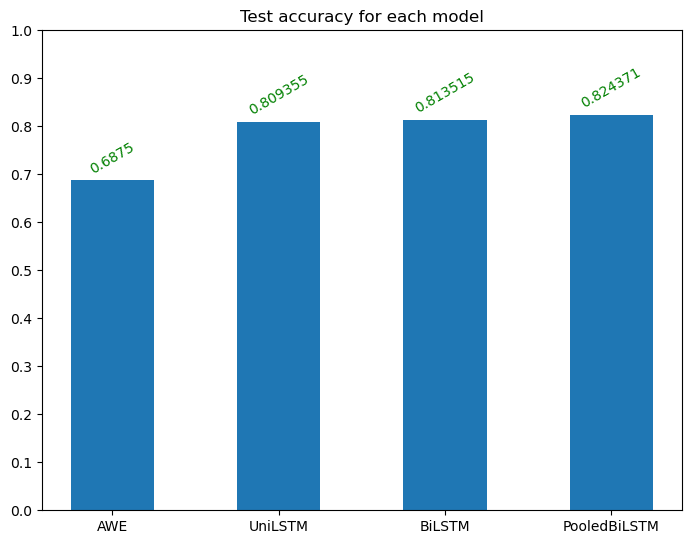

In [9]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
model_names = ['AWE', 'UniLSTM', 'BiLSTM', 'PooledBiLSTM']
test_accs = [test_acc_AWE,test_acc_UniLSTM,test_acc_BiLSTM,test_acc_PooledBiLSTM]
ax.bar(model_names,test_accs, width=0.5)
ax.bar_label(ax.containers[0], label_type='edge', color='green', rotation=30, fontsize=10, padding=3)
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.title("Test accuracy for each model")
plt.show()

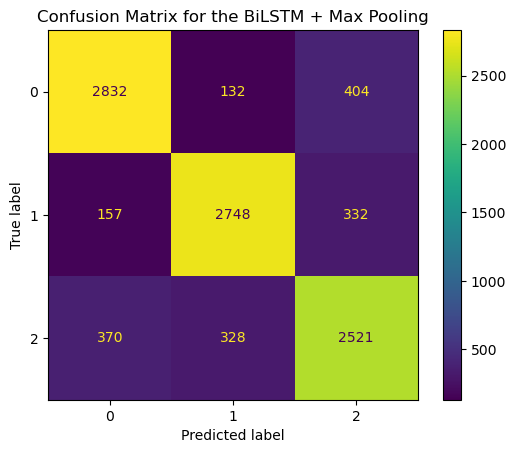

In [10]:
confusion_matrix = metrics.confusion_matrix(np.array(torch.cat(pooled_labels, dim=0)), np.array(torch.cat(pooled_preds, dim=0)))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
disp.plot()
plt.title('Confusion Matrix for the BiLSTM + Max Pooling')
plt.show()

## Inference

We shall now check what the model predicts on random unseen sentences. Let us consider the premise:
- Premise : "Nick is cooking at his kitchen."

And three hypothesis sentences:
- Hypothesis 1 : "He uses the oven."
- Hypothesis 2 : "Nick is doing his homework."
- Hypothesis 3 : "He is wearing a suit."

A human judge would label the relationship between the premise and the hypothesis sentences as entailment, contradiction and neutral respectively.

In [11]:
def predict(model, premise, hypothesis,preprocess_premise, preprocess_hypothesis):
    if preprocess_premise == True: 
        premise = snli_data.text.process([snli_data.text.preprocess(premise)])
    if preprocess_hypothesis == True: 
        hypothesis = snli_data.text.process([snli_data.text.preprocess(hypothesis)])

    model.eval()
    with torch.no_grad():
        output = model(premise=premise[0], premise_length=premise[1], hypothesis=hypothesis[0], hypothesis_length=hypothesis[1])
        output = torch.softmax(output, dim=1)
        predictions = torch.argmax(output, dim=1)
        

    if predictions == 0:
        label = "Entailment"
    elif predictions == 1:
        label = "Contradiction"
    else:
        label = "Neutral"

    return label

result1 = predict(PooledBiLSTM_model, "Nick is cooking at the kitchen", "He uses the oven", True, True)
result2 = predict(PooledBiLSTM_model, "Nick is cooking at his kitchen", "Nick is doing his homework", True, True)
result3 = predict(PooledBiLSTM_model, "Nick is cooking at his kitchen", "He is wearing a suit", True, True)

print("Premise - Hypothesis 1 :" ,result1)
print("Premise - Hypothesis 2 :" ,result2)
print("Premise - Hypothesis 3 :" ,result3)

Premise - Hypothesis 1 : Entailment
Premise - Hypothesis 2 : Contradiction
Premise - Hypothesis 3 : Neutral


The model indeed performed well, as it predicted correctly the labels for every case. We can know check what the model predicts given the premise and the hypothesis in the description of the exercise.

- Premise1 : "Two men sitting in the sun"
- Hypothesis1 : "Nobody is sitting in the shade"

And the second example is the following:


- Premise1 : "A man is walking a dog"
- Hypothesis1 : "No cat is outside"

In [12]:
result4 = predict(PooledBiLSTM_model, "Two men sitting in the sun", "Nobody is sitting in the shade",True, True)
result5 = predict(PooledBiLSTM_model, "A man is walking a dog", "No cat is outside",True, True)
print("The MaxPooled BiLSTM's prediction for the first pair of sentences (Premise - Hypothesis) is :" ,result4)
print("The MaxPooled BiLSTM's prediction for the second pair of sentences (Premise - Hypothesis) is :" ,result5)

result6 = predict(AWE_model, "Two men sitting in the sun", "Nobody is sitting in the shade",True, True)
result7 = predict(AWE_model, "A man is walking a dog", "No cat is outside",True, True)
print("The AWE model's prediction for the first pair of sentences (Premise - Hypothesis) is :" ,result6)
print("The AWE model's prediction for the second pair of sentences (Premise - Hypothesis) is :" ,result7)

result8 = predict(UniLSTM_model, "Two men sitting in the sun", "Nobody is sitting in the shade",True, True)
result9 = predict(UniLSTM_model, "A man is walking a dog", "No cat is outside",True, True)
print("The UniLSTM's prediction for the first pair of sentences (Premise - Hypothesis) is :" ,result8)
print("The UniLSTM's prediction for the second pair of sentences (Premise - Hypothesis) is :" ,result9)

result10 = predict(BiLSTM_model, "Two men sitting in the sun", "Nobody is sitting in the shade",True, True)
result11 = predict(BiLSTM_model, "A man is walking a dog", "No cat is outside",True, True)
print("The BiLSTM's prediction for the first pair of sentences (Premise - Hypothesis) is :" ,result10)
print("The BiLSTM's prediction for the second pair of sentences (Premise - Hypothesis) is :" ,result11)


The MaxPooled BiLSTM's prediction for the first pair of sentences (Premise - Hypothesis) is : Contradiction
The MaxPooled BiLSTM's prediction for the second pair of sentences (Premise - Hypothesis) is : Contradiction
The AWE model's prediction for the first pair of sentences (Premise - Hypothesis) is : Contradiction
The AWE model's prediction for the second pair of sentences (Premise - Hypothesis) is : Contradiction
The UniLSTM's prediction for the first pair of sentences (Premise - Hypothesis) is : Contradiction
The UniLSTM's prediction for the second pair of sentences (Premise - Hypothesis) is : Contradiction
The BiLSTM's prediction for the first pair of sentences (Premise - Hypothesis) is : Contradiction
The BiLSTM's prediction for the second pair of sentences (Premise - Hypothesis) is : Contradiction


The sentences do not have to be extremely complex to make the model fail.

In [24]:
fail_scenario = predict(PooledBiLSTM_model, "Nick is a very well known football player", "Nick plays as the goalkeeper for a team", True, True)
print("The prediction the model made is :" ,fail_scenario)
fail_scenario1 = predict(PooledBiLSTM_model, "Nick is cooking dinner now", "He is wearing a new suit", True, True)
print("The prediction the model made is :" ,fail_scenario1)

The prediction the model made is : Neutral
The prediction the model made is : Contradiction


Even in the above case, which is  simple the model, fails to predict the correct label (i.e. entailment). This makes the model unreliable, because in both sentences the subject ("Nick") is the same and football is directly related with the word "goalkeeper" and player is also connected with the word "plays". In the second case, the correct label is neutral, since these two sentences are not relevant with each other, but the model predicts contradiction.

In [25]:
premise = snli_data.text.process([snli_data.text.preprocess("Nick is a very well known football player")])
hypothesis = snli_data.text.process([snli_data.text.preprocess("Nick plays as the goalkeeper for a team")])
cos_sim = torch.nn.CosineSimilarity(dim=1, eps=1e-6)(premise[0].float(),hypothesis[0].float())
print("In the first case, the cosine similarity of the given sentences is :",cos_sim.item())

premise_contr = snli_data.text.process([snli_data.text.preprocess("Nick is cooking dinner now")])
hypothesis_contr = snli_data.text.process([snli_data.text.preprocess("He is wearing a suit")])
cos_sim_contr = torch.nn.CosineSimilarity(dim=1, eps=1e-6)(premise_contr[0].float(),hypothesis_contr[0].float())
print("In the second case, the cosine similarity of the given sentences is :",cos_sim_contr.item())

In the first case, the cosine similarity of the given sentences is : 0.9365578889846802
In the second case, the cosine similarity of the given sentences is : 0.6007154583930969


We notice that similarity of the two sentences in the first case is pretty high. Although, this might be some sort of indication for the label, we can not just trust this metric blindly. Namely:
- High cosine similarity between the premise and the hypothesis does not necessarily mean that the model will predict entailment (as displayed above)
- Low cosine similarity between the premise and the hypothesis most of the times means that the model will predict contradiction (kind of biased towards it as analysed below)
- Inbetween values of the cosine similarity usually means that the model will probably predict contradiction (as displayed above)

Nevertheless the cosine similarity can play a significant role if it gets incorporated in the model. This is because it can provide additional information about the inputs to the model, so it gets a better understanding of what label it should give.


## How the length of a sentence affect the label?

In the previous section, we saw that the model correctly predicted the label in all three scenarios:
- Premise : "Nick is cooking at his kitchen."
- Hypothesis 1 : "He uses the oven"
- Hypothesis 2 : "Nick is doing his homework"
- Hypothesis 3 : "He is wearing a suit"

We will now add some more words to each hypothesis without changing the overall meaning of the sentence. So in this case, we have the following sentences:

- Hypothesis 1 : "He uses the oven to cook some vegetables"
- Hypothesis 2 : "Nick is doing his homework which is really difficult"
- Hypothesis 3 : "He is wearing a suit and some new shoes"

In [26]:
new_result1 = predict(PooledBiLSTM_model, "Nick is cooking at the kitchen", "He uses the oven to make some pork with vegetables", True, True)
new_result2 = predict(PooledBiLSTM_model, "Nick is cooking at his kitchen", "Nick is doing his homework which is really difficult", True, True)
new_result3 = predict(PooledBiLSTM_model, "Nick is cooking at his kitchen", "He is wearing a suit and some new shoes", True, True)
print("MaxPooled BiLSTM for Premise - Hypothesis 1 :" ,new_result1)
print("MaxPooled BiLSTM for Premise - Hypothesis 2 :" ,new_result2)
print("MaxPooled BiLSTM for Premise - Hypothesis 3 :" ,new_result3)
new_result5 = predict(AWE_model, "Nick is cooking at the kitchen", "He uses the oven to make some pork with vegetables", True, True)
new_result6 = predict(AWE_model, "Nick is cooking at his kitchen", "Nick is doing his homework which is really difficult", True, True)
new_result7 = predict(AWE_model, "Nick is cooking at his kitchen", "He is wearing a suit and some new shoes", True, True)
print("AWE for Premise - Hypothesis 1 :" ,new_result5)
print("AWE for Premise - Hypothesis 2 :" ,new_result6)
print("AWE for Premise - Hypothesis 3 :" ,new_result7)
new_result8 = predict(UniLSTM_model, "Nick is cooking at the kitchen", "He uses the oven to make some pork with vegetables", True, True)
new_result9 = predict(UniLSTM_model, "Nick is cooking at his kitchen", "Nick is doing his homework which is really difficult", True, True)
new_result10 = predict(UniLSTM_model, "Nick is cooking at his kitchen", "He is wearing a suit and some new shoes", True, True)
print("UniLSTM for Premise - Hypothesis 1 :" ,new_result8)
print("UniLSTM for Premise - Hypothesis 2 :" ,new_result9)
print("UniLSTM for Premise - Hypothesis 3 :" ,new_result10)
new_result11 = predict(BiLSTM_model, "Nick is cooking at the kitchen", "He uses the oven to make some pork with vegetables", True, True)
new_result12 = predict(BiLSTM_model, "Nick is cooking at his kitchen", "Nick is doing his homework which is really difficult", True, True)
new_result13 = predict(BiLSTM_model, "Nick is cooking at his kitchen", "He is wearing a suit and some new shoes", True, True)
print("BiLSTM_model for Premise - Hypothesis 1 :" ,new_result11)
print("BiLSTM_model for Premise - Hypothesis 2 :" ,new_result12)
print("BiLSTM_model for Premise - Hypothesis 3 :" ,new_result13)

MaxPooled BiLSTM for Premise - Hypothesis 1 : Neutral
MaxPooled BiLSTM for Premise - Hypothesis 2 : Contradiction
MaxPooled BiLSTM for Premise - Hypothesis 3 : Contradiction
AWE for Premise - Hypothesis 1 : Neutral
AWE for Premise - Hypothesis 2 : Neutral
AWE for Premise - Hypothesis 3 : Neutral
UniLSTM for Premise - Hypothesis 1 : Neutral
UniLSTM for Premise - Hypothesis 2 : Contradiction
UniLSTM for Premise - Hypothesis 3 : Contradiction
BiLSTM_model for Premise - Hypothesis 1 : Neutral
BiLSTM_model for Premise - Hypothesis 2 : Contradiction
BiLSTM_model for Premise - Hypothesis 3 : Contradiction


A clear example that demonstrates the bias towards contradiction is the following:

In [27]:
new_result4 = predict(PooledBiLSTM_model, "An animal is in my kitchen", "A cat sits on my stove", True, True)
print("The model predicts the relation as :", new_result4, "\nwhereas the correct label is : Entailment")

The model predicts the relation as : Contradiction 
whereas the correct label is : Entailment


We reach to the conclusion that adding new words to the original sentences completely changes the prediction of the model, despite the fact that overall meaning of the sentence is the same. This in fact supports our arguement that the model is biased towards contradiction. In every case, the more words we add to the hypothesis, the more likely the model will predict that the label is contradiction.  

The first thing that comes in mind is that the dataset might contain more examples of contradiction and thus the model is more biased towards them, but this is not the case according to the following cell (i.e. there's no class imbalance).

In [28]:
count_entailment_labels = 0
count_contradiction_labels = 0
count_neutral_labels = 0
for (_, _, labels) in tqdm(train_loader):
    labels = labels
    for label in labels:
        label = label.numpy()
        if label == 0:
            count_entailment_labels +=1 
        elif label ==1:
            count_contradiction_labels += 1
        elif label ==2:
            count_neutral_labels +=1
print("The number of entailment labels in the train dataset is" ,count_entailment_labels)
print("The number of contradiction labels in the train dataset is" ,count_contradiction_labels)
print("The number of neutral labels in the train dataset is" ,count_neutral_labels)

100%|██████████| 8584/8584 [00:09<00:00, 940.40it/s] 

The number of entailment labels in the train dataset is 183416
The number of contradiction labels in the train dataset is 183187
The number of neutral labels in the train dataset is 182764


As long as the labels are equally distributed in the train dataset, this means that there is probably some bias inserted by the encoder. Specifically, it might be something to do with the encoders that use LSTMs, since the AWE model predicted neutral when we added more words to the sentences.

## Active vs Passive voice & Different Tenses

I want to start off this section by clarifying that MaxPooled BiLSTM's better performance on the train/valid/test set does not mean it is always the best choice.

The example below demonstrates how the different voices can affect the label:
- Premise : "Nick ate the whole pizza"
- Hypothesis : "The pizza was eaten by Nick"

Clearly the meaning is the same and the model should label it as an entailment.

In [29]:
voice_label = predict(PooledBiLSTM_model, "Nick ate the whole pizza", "The pizza was eaten by Nick", True, True)
print("The BiLSTM + Max Pooling model predicts : ",voice_label)
voice_label1 = predict(AWE_model, "Nick ate the whole pizza", "The pizza was eaten by Nick", True, True)
print("The AWE model predicts : ",voice_label1)
voice_label2 = predict(UniLSTM_model, "Nick ate the whole pizza", "The pizza was eaten by Nick", True, True)
print("The UniLSTM model predicts : ",voice_label2)
voice_label3 = predict(BiLSTM_model, "Nick ate the whole pizza", "The pizza was eaten by Nick", True, True)
print("The BiLSTM model predicts : ",voice_label3)

The BiLSTM + Max Pooling model predicts :  Contradiction
The AWE model predicts :  Entailment
The UniLSTM model predicts :  Neutral
The BiLSTM model predicts :  Entailment


So we reach to the conclusion that:
- The use of active or passive voice affects the model's prediction
- MaxPooled BiLSTM is not always the best option. Here, even the simple AWE model predicted the correct label (BiLSTM as well), whereas UniLSTM and MaxPooled BiLSTM did not.

It is worth saying that the AWE model's training required less time and fewer computational resources than the other models.

Apart from the different voices, we can also change the tense, without changing the overall meaning of the sentence. For instance:
- Premise: "Nick has taken the car for a ride"
- Hypothesis: "Nick is outside"

In [30]:
tense1 = predict(PooledBiLSTM_model, "Nick has taken the car for a ride", "Nick is outside", True, True)
print("The BiLSTM + Max Pooling model predicts : ",tense1)
tense2 = predict(AWE_model, "Nick has taken the car for a ride", "Nick is outside", True, True)
print("The AWE model predicts : ",tense2)
tense3 = predict(UniLSTM_model, "Nick has taken the car for a ride", "Nick is outside", True, True)
print("The UniLSTM model predicts : ",tense3)
tense4 = predict(BiLSTM_model, "Nick has taken the car for a ride", "Nick is outside", True, True)
print("The BiLSTM model predicts : ",tense4)

The BiLSTM + Max Pooling model predicts :  Entailment
The AWE model predicts :  Contradiction
The UniLSTM model predicts :  Entailment
The BiLSTM model predicts :  Entailment


In this case the models that use LSTMs outperform the simple AWE model, where the naive approach fails to predict the correct label.

## Does word order matter?

The AWE Encoder does not take the word order into consideration, but still performs decent. However, we can see that we once add an LSTM then the performance increases sharply. LSTMs are capable of capturing long-term dependencies in the input sequence thanks to the memory cell, which can store information and selectively forget or add new information as it sees fit. In general, LSTMs can learn to model the dependencies between words and their positions in the sentence. So what would happen if we shuffle the words in the sentence?

In [31]:
torch.manual_seed(0)

def word_order(model,sentence):
    original_sentence = snli_data.text.process([snli_data.text.preprocess(sentence)])
    indices = torch.randperm(original_sentence[0].shape[1])
    shuffled_sentence = (original_sentence[0][:,indices],original_sentence[1])
    original_embedding = model.embedding_layer(original_sentence[0])
    shuffled_embedding = model.embedding_layer(shuffled_sentence[0])
    output1 = model.encoder(original_embedding, original_sentence[1])
    output2 = model.encoder(shuffled_embedding, original_sentence[1])
    return original_sentence, shuffled_sentence,output1,output2

original_sentence1, shuffled_sentence1,original_output1,shuffled_output1 = word_order(AWE_model, 'He is wearing a suit')
original_sentence2, shuffled_sentence2,original_output2,shuffled_output2 = word_order(PooledBiLSTM_model, 'He is wearing a suit')
original_sentence3, shuffled_sentence3,original_output3,shuffled_output3 = word_order(UniLSTM_model, 'He is wearing a suit')
original_sentence4, shuffled_sentence4,original_output4,shuffled_output4 = word_order(BiLSTM_model, 'He is wearing a suit')

print("\nThe predictions of each model with the original and the shuffled hypothesis are :")
result_with_original_awe = predict(AWE_model, "Nick is cooking at his kitchen", original_sentence1, True, False)
result_with_shuffled_awe = predict(AWE_model, "Nick is cooking at his kitchen", shuffled_sentence1, True, False)
print("AWE | \t\tOriginal hypothesis : ",result_with_original_awe, "\t | Shuffled hypothesis :", result_with_shuffled_awe)

result_with_original_pooled = predict(PooledBiLSTM_model, "Nick is cooking at his kitchen", original_sentence2, True, False)
result_with_shuffled_pooled = predict(PooledBiLSTM_model, "Nick is cooking at his kitchen", shuffled_sentence2, True, False)
print("MaxPoolBiLSTM | Original hypothesis : ",result_with_original_pooled, "\t | Shuffled hypothesis :", result_with_shuffled_pooled)

result_with_original_uni = predict(UniLSTM_model, "Nick is cooking at his kitchen", original_sentence3, True, False)
result_with_shuffled_uni = predict(UniLSTM_model, "Nick is cooking at his kitchen", shuffled_sentence3, True, False)
print("UniLSTM | \tOriginal hypothesis : ",result_with_original_uni, "\t | Shuffled hypothesis :", result_with_shuffled_uni)

result_with_original_bi = predict(BiLSTM_model, "Nick is cooking at his kitchen", original_sentence4, True, False)
result_with_shuffled_bi = predict(BiLSTM_model, "Nick is cooking at his kitchen", shuffled_sentence4, True, False)
print("BiLSTM | \tOriginal hypothesis : ",result_with_original_bi, "\t | Shuffled hypothesis :", result_with_shuffled_bi)

print("\nThe cosine similarity of the encoded embeddings of the original and the shuffled sentence for each model is :")
print("AWE : " "%.2f" % torch.nn.CosineSimilarity(dim=1, eps=1e-5)(original_output1,shuffled_output1).item())
print("UniLSTM : " "%.2f" % torch.nn.CosineSimilarity(dim=1, eps=1e-5)(original_output3,shuffled_output3).item())
print("BiLSTM : " "%.2f" % torch.nn.CosineSimilarity(dim=1, eps=1e-5)(original_output4,shuffled_output4).item())
print("MaxPooledBiLSTM : " "%.2f" % torch.nn.CosineSimilarity(dim=1, eps=1e-5)(original_output2,shuffled_output2).item())


The predictions of each model with the original and the shuffled hypothesis are :
AWE | 		Original hypothesis :  Neutral 	 | Shuffled hypothesis : Neutral
MaxPoolBiLSTM | Original hypothesis :  Neutral 	 | Shuffled hypothesis : Contradiction
UniLSTM | 	Original hypothesis :  Contradiction 	 | Shuffled hypothesis : Neutral
BiLSTM | 	Original hypothesis :  Contradiction 	 | Shuffled hypothesis : Contradiction

The cosine similarity of the encoded embeddings of the original and the shuffled sentence for each model is :
AWE : 1.00
UniLSTM : 0.74
BiLSTM : 0.77
MaxPooledBiLSTM : 0.86


Consequently, the word order matters and provides useful information. From the results above, we can see that the AWE which doesn't take the word order into consideration and predicts the same label regardless if it's given the original or the shuffled hypothesis. The same holds for the BiLSTM, but it gives the wrong label - Contradiction, when the correct label is Neutral. On the other hand, a BiLSTM using Max Pooling and UniLSTM give different labels if they are given shuffled intput, but the UniLSTM gives wrong label with the original hypothesis.
Therefore, we can consider this example as a case where the AWE model can sometimes be a better option than the other models. The fact that LSTMs are order sensitive can be seen by the cosine similarity of the encoded embeddings for the original and the shuffled input sentence.

## What information does the sentence embedding represent, and what information might be lost?

The SNLI dataset consists of pairs of sentences (premise and hypothesis) and a label indicating the relationship between them. The sentence embeddings in the model represent the meanings of the premise and hypothesis sentences and are used as input to the MLP classifier to predict the relationship between them. The information that the sentence embeddings represent, in general, high-level semantic features of the sentences. To give an example, given the sentence "The cat sat on the mat", the high-level semantic features of this sentence might include that it is about a cat and a mat, and that the cat is sitting on the mat. 

For the types of encoder used in this project, we can tell that:

1. AWE: The sentence embedding in this case represents the overall meaning of the sentence based on the meanings of its constituent words. This approach may lose some information about word order and sentence structure as shown above.

2. Unidirectional LSTM: This model sequentially reads the words in the sentence from left to right and outputs a hidden state for each word. The final hidden state of the LSTM is used as the sentence embedding. This approach can capture the sequential dependencies between words and can represent the context in which each word appears in the sentence. This approach, however, may not capture information from the right context of the sentence.

3. Bidirectional LSTM: This model reads the words in the sentence from left to right and from right to left, resulting in two hidden states for each word. The final hidden states from both directions are concatenated to create the sentence embedding. This approach can capture both the sequential dependencies between words and the context in which each word appears in the sentence. However, this approach may still not capture some long-range dependencies between words. It is shown above that when the input sentence are larger in size (and therefore long-range dependencies might come up), the model is biased towards predicting contradiction.

4. Bidirectional LSTM + Max Pooling : This model can also capture information from both the left and right contexts of each word in the sentence, allowing it to capture more comprehensive information about the sentence's meaning. The max pooling operation then extracts the most salient information from the hidden states. However, it is unclear whether this approach can maintain some information about the exact positions of the most important words in the sentence.

Consequently, we can see that in a sequential order, a model can solve the problems - limitations of the previous model.
